In [73]:
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from time import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [35]:
# load the dataset
# the optional parameter: min_faces_per_person: 
# will only retain pictures of people that have at least min_faces_per_person different pictures.
# the optional parameter: resize is the ratio used to resize the each face picture.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [36]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
n_samples, h, w

(1288, 50, 37)

In [37]:
# for machine learning we use the data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
y = lfw_people.target
n_features = X.shape[1]

In [38]:
X.shape

(1288, 1850)

'Hugo Chavez'

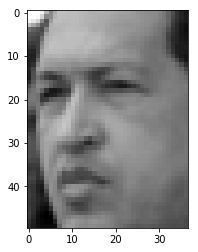

In [39]:
# plot one of the faces
plt.imshow(X[0].reshape((h, w)), cmap=plt.cm.gray)
lfw_people.target_names[y[0]]

'Hugo Chavez'

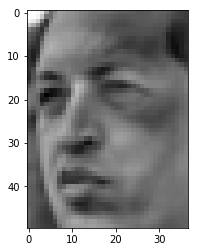

In [40]:
# plot one of the faces after applying a scaling modujle
from sklearn.preprocessing import StandardScaler

plt.imshow(StandardScaler().fit_transform(X)[0].reshape((h, w)), cmap=plt.cm.gray)
lfw_people.target_names[y[0]]

In [41]:
# the label to predict is the id of the person
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [61]:
# let's split our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [62]:

"""
Compute a PCA (eigenfaces) on the face dataset 

from sklearn docs:
The optional parameter whiten=True makes it possible to project the data onto the singular space 
while scaling each component to unit variance. This is often useful if the models down-stream make strong 
assumptions on the isotropy of the signal: this is for example the case for 
Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.
"""

# instantiate the PCA module
pca = PCA(n_components=200, whiten=True)

# create a pipeline called preprocessing that will scale data and then apply PCA
preprocessing = Pipeline([('scale', StandardScaler()), ('pca', pca)])

print "Extracting the top %d eigenfaces from %d faces" % (200, X_train.shape[0])

# fit the pipeline to the training set
preprocessing.fit(X_train)

# grab the PCA from the pipeline
extracted_pca = preprocessing.steps[1][1]

Extracting the top 200 eigenfaces from 966 faces


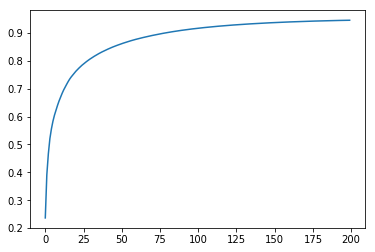

In [63]:
# Scree Plot

plt.plot(np.cumsum(extracted_pca.explained_variance_ratio_))

# starting at 100 components captures over 90% of the variance compared to the 1,850 original features

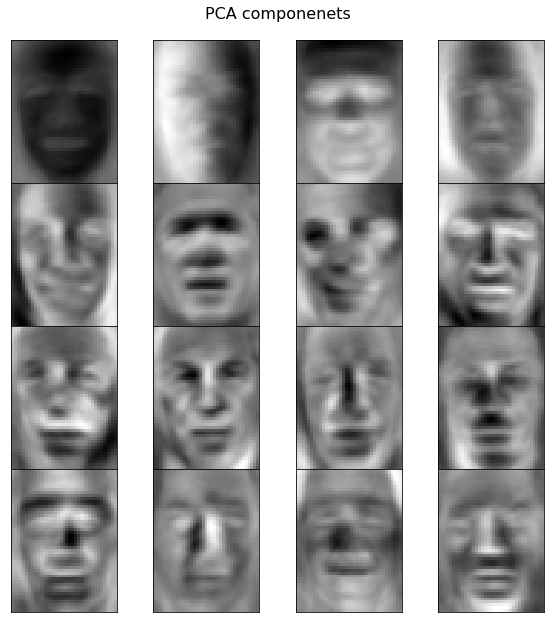

In [168]:
comp = extracted_pca.components_
image_shape = (h, w)
def plot_gallery(title, images, n_col, n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()    
plot_gallery('PCA componenets', comp[:16], 4,4)

In [65]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints a more readable confusion matrix with heat labels and options for noramlization
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0.813664596273 Accuracy score for best estimator
                   precision    recall  f1-score   support

     Ariel Sharon       0.72      0.68      0.70        19
     Colin Powell       0.85      0.71      0.77        55
  Donald Rumsfeld       0.62      0.72      0.67        25
    George W Bush       0.88      0.91      0.89       142
Gerhard Schroeder       0.79      0.84      0.81        31
      Hugo Chavez       0.87      0.81      0.84        16
       Tony Blair       0.71      0.71      0.71        34

      avg / total       0.82      0.81      0.81       322

None
39.9 seconds to grid search and predict the test set


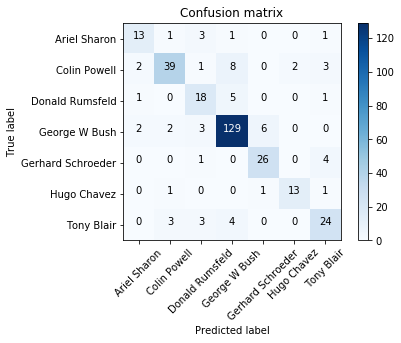

In [66]:
# fit without using PCA to see what the difference will be
t0 = time()

param_grid = {'C': [1e-2, 1e-1,1e0,1e1, 1e2]}
clf = GridSearchCV(logreg, param_grid)
clf = clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# Predicting people's names on the test set
y_pred = best_clf.predict(X_test)

print accuracy_score(y_pred, y_test), "Accuracy score for best estimator"
print(classification_report(y_test, y_pred, target_names=target_names))
print plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=range(n_classes)), target_names)
print round((time() - t0), 1), "seconds to grid search and predict the test set"

0.739130434783 Accuracy score for best estimator
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.63      0.65        19
     Colin Powell       0.69      0.60      0.64        55
  Donald Rumsfeld       0.74      0.68      0.71        25
    George W Bush       0.76      0.88      0.82       142
Gerhard Schroeder       0.77      0.77      0.77        31
      Hugo Chavez       0.62      0.62      0.62        16
       Tony Blair       0.77      0.50      0.61        34

      avg / total       0.74      0.74      0.73       322

None
74.5 seconds to grid search and predict the test set


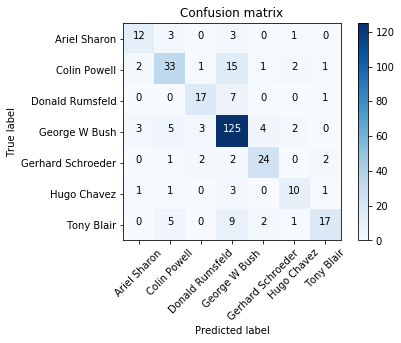

In [69]:
# fit with using PCA to see what the difference will be
t0 = time()

face_pipeline = Pipeline(steps=[('PCA', PCA(n_components=200)), ('logistic', logreg)])

pipe_param_grid = {'logistic__C': [1e-2, 1e-1,1e0,1e1, 1e2]}
clf = GridSearchCV(face_pipeline, pipe_param_grid)
clf = clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# Predicting people's names on the test set
y_pred = best_clf.predict(X_test)

print accuracy_score(y_pred, y_test), "Accuracy score for best estimator"
print(classification_report(y_test, y_pred, target_names=target_names))
print plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=range(n_classes)), target_names)
print round((time() - t0), 1), "seconds to grid search and predict the test set"

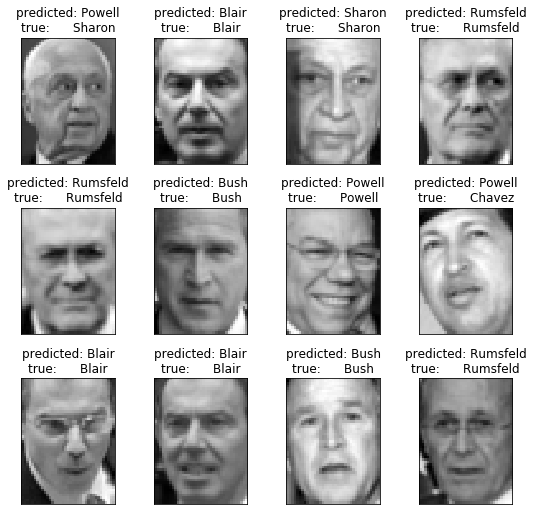

In [70]:
# get a list of predicted names and true names to plot with faces in test set
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

# splot a sample of the test set with predicted and true names
plot_gallery(X_test, prediction_titles, h, w)

In [71]:
def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model,           # the model to grid search
                        params,          # the parameter set to try 
                        error_score=0.)  # if a parameter set raises an error, continue and set the performance as a big, fat 0
    grid.fit(X, y)           # fit the model and parameters
    # our classical metric for performance
    print "Best Accuracy: {}".format(grid.best_score_)
    # the best parameters that caused the best accuracy
    print "Best Parameters: {}".format(grid.best_params_)
    # the average time it took a model to fit to the data (in seconds)
    print "Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3))
    # the average time it took a model to predict out of sample data (in seconds)
    # this metric gives us insight into how this model will perform in real-time analysis
    print "Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3))

In [74]:
# Create a larger pipeline to gridsearch
face_params = {'logistic__C':[1e-2, 1e-1, 1e0, 1e1, 1e2], 
               'preprocessing__pca__n_components':[100, 150, 200, 250, 300],
               'preprocessing__pca__whiten':[True, False],
               'preprocessing__lda__n_components':range(1, 7)  
               # [1, 2, 3, 4, 5, 6] recall the max allowed is n_classes-1
              }

pca = PCA()
lda = LinearDiscriminantAnalysis()

preprocessing = Pipeline([('scale', StandardScaler()), ('pca', pca), ('lda', lda)])

logreg = LogisticRegression()
face_pipeline = Pipeline(steps=[('preprocessing', preprocessing), ('logistic', logreg)])

get_best_model_and_accuracy(face_pipeline, face_params, X, y)

/Users/sinanozdemir/Desktop/features/env/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Best Accuracy: 0.835403726708
Best Parameters: {'logistic__C': 100.0, 'preprocessing__pca__n_components': 150, 'preprocessing__lda__n_components': 5, 'preprocessing__pca__whiten': False}
Average Time to Fit (s): 0.267
Average Time to Score (s): 0.011


In [ ]:
# much better than original data and very fast to predict and train!

# talk about how these transformations are dope BUT they are predefined so we could learn new features 
# based on training data

# these predefined transformations might not work for a particular dataset 
# PCA is PCA no matter what dataset you choose to work with

In [148]:
from sklearn.neural_network import BernoulliRBM
from sklearn.preprocessing import MinMaxScaler

In [160]:
extracted_rbm.components_.shape

(12, 1850)

In [176]:
# instantiate the PCA module
rbm = BernoulliRBM(n_components=200, learning_rate=0.01, batch_size=10, n_iter=200, verbose=True)

# create a pipeline called preprocessing that will scale data and then apply PCA
preprocessing = Pipeline([('minmax', MinMaxScaler()), ('rbm', rbm)])

print "Extracting the top %d RBM-faces from %d faces" % (200, X_train.shape[0])

# fit the pipeline to the training set
preprocessing.fit(X_train)

# grab the PCA from the pipeline
extracted_rbm = preprocessing.steps[1][1]

Extracting the top 200 RBM-faces from 966 faces
[BernoulliRBM] Iteration 1, pseudo-likelihood = -1252.01, time = 0.53s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -1243.62, time = 0.61s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -1233.08, time = 0.51s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -1218.86, time = 0.50s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -1214.77, time = 0.47s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -1229.27, time = 0.47s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -1228.32, time = 0.49s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -1222.11, time = 0.47s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -1211.49, time = 0.45s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -1197.88, time = 0.50s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -1222.48, time = 0.48s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -1196.49, time = 1.20s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -1209.07, time = 0.57s
[BernoulliRBM] Iteration 

[BernoulliRBM] Iteration 115, pseudo-likelihood = -1164.84, time = 0.46s
[BernoulliRBM] Iteration 116, pseudo-likelihood = -1175.96, time = 0.45s
[BernoulliRBM] Iteration 117, pseudo-likelihood = -1172.21, time = 0.45s
[BernoulliRBM] Iteration 118, pseudo-likelihood = -1174.42, time = 0.45s
[BernoulliRBM] Iteration 119, pseudo-likelihood = -1161.25, time = 0.46s
[BernoulliRBM] Iteration 120, pseudo-likelihood = -1159.76, time = 0.45s
[BernoulliRBM] Iteration 121, pseudo-likelihood = -1177.25, time = 0.45s
[BernoulliRBM] Iteration 122, pseudo-likelihood = -1170.25, time = 0.48s
[BernoulliRBM] Iteration 123, pseudo-likelihood = -1161.02, time = 0.46s
[BernoulliRBM] Iteration 124, pseudo-likelihood = -1164.29, time = 0.45s
[BernoulliRBM] Iteration 125, pseudo-likelihood = -1173.03, time = 0.45s
[BernoulliRBM] Iteration 126, pseudo-likelihood = -1160.94, time = 0.46s
[BernoulliRBM] Iteration 127, pseudo-likelihood = -1163.14, time = 0.48s
[BernoulliRBM] Iteration 128, pseudo-likelihood = -

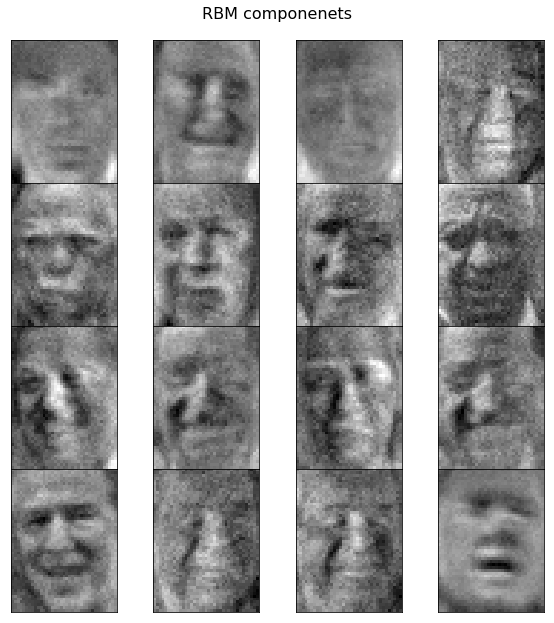

In [177]:
comp = extracted_rbm.components_
image_shape = (h, w)
def plot_gallery(title, images, n_col, n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()    
plot_gallery('RBM componenets', comp[:16], 4,4)

In [75]:
# latent semantic analysis is a name given to the process of doing an SVD on sparse text document-term matricies
# It is done to find latent structure in text for the purposes of classification, clustering, etc

In [90]:
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
import pandas as pd
# import the sentence tokenizer from nltk
from nltk.tokenize import sent_tokenize
from sklearn.decomposition import TruncatedSVD

In [91]:
hotel_reviews = pd.read_csv('../data/7282_1.csv')

In [92]:
hotel_reviews.shape

(35912, 19)

In [93]:
hotel_reviews.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


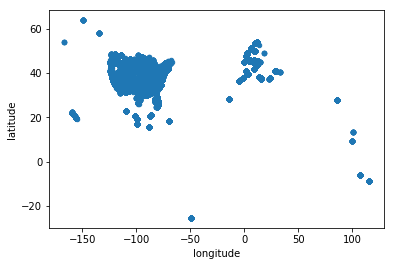

In [94]:
# Let's only include reviews from the US to try to only include english reviews

# plot the lats and longs of reviews
hotel_reviews.plot.scatter(x='longitude', y='latitude')

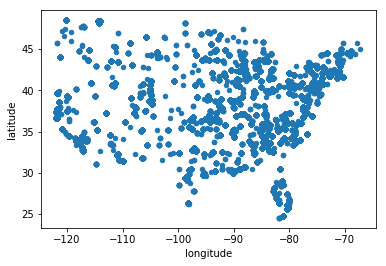

In [95]:
#Filter to only include datapoints within the US
hotel_reviews = hotel_reviews[((hotel_reviews['latitude']<=50.0) & (hotel_reviews['latitude']>=24.0)) & ((hotel_reviews['longitude']<=-65.0) & (hotel_reviews['longitude']>=-122.0))]

# Plot the lats and longs again
hotel_reviews.plot.scatter(x='longitude', y='latitude')
# Only looking at reviews that are coming from the US

In [96]:
hotel_reviews.shape

(30692, 19)

In [99]:
texts = hotel_reviews['reviews.text']

In [100]:
sent_tokenize("hello! I am Sinan. How are you??? I am fine")

['hello!', 'I am Sinan.', 'How are you???', 'I am fine']

In [101]:
sentences = reduce(lambda x, y:x+y, texts.apply(lambda x: sent_tokenize(str(x).decode('utf-8'))))

In [102]:
# the number of sentences
len(sentences)

118151

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

tfidf_transformed = tfidf.fit_transform(sentences)

tfidf_transformed

<118151x280901 sparse matrix of type '<type 'numpy.float64'>'
	with 1180273 stored elements in Compressed Sparse Row format>

In [104]:
# try to fit PCA

PCA(n_components=1000).fit(tfidf_transformed)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [110]:
# import the Iris dataset from scikit-learn
from sklearn.datasets import load_iris
# import our plotting module
import matplotlib.pyplot as plt
%matplotlib inline

# load the Iris dataset
iris = load_iris()

# seperate the features and response variable
iris_X, iris_y = iris.data, iris.target

X_centered = StandardScaler(with_std=False).fit_transform(iris_X)
X_scaled = StandardScaler().fit_transform(iris_X)

In [111]:
# can't work because it has to calculate a covariance matrix and to do that, the matrix needs to be dense
# we use another method in sklearn called Truncated SVD
# Truncated SVD uses a matrix trick to obtain the same components as PCA (when the data are scaled)
# and can work with sparse matrices

# components are a not exactly equal but they are up to a very precise decimal

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
pca = PCA(n_components=2)

# check if components of PCA and TruncatedSVD are same for a dataset
# by substracting the two matricies and seeing if, on average, the elements are very close to 0
print (pca.fit(iris_X).components_ - svd.fit(iris_X).components_).mean()  # not close to 0
# matrices are NOT the same

# check if components of PCA and TruncatedSVD are same for a centered dataset
print (pca.fit(X_centered).components_ - svd.fit(X_centered).components_).mean()  # close to 0
# matrices ARE the same

# check if components of PCA and TruncatedSVD are same for a scaled dataset
print (pca.fit(X_scaled).components_ - svd.fit(X_scaled).components_).mean()  # close to 0
# matrices ARE the same


0.130183123094
-5.03069808033e-17
-6.63531729561e-17


In [112]:
svd = TruncatedSVD(n_components=1000)
svd.fit(tfidf_transformed)

TruncatedSVD(algorithm='randomized', n_components=1000, n_iter=5,
       random_state=None, tol=0.0)

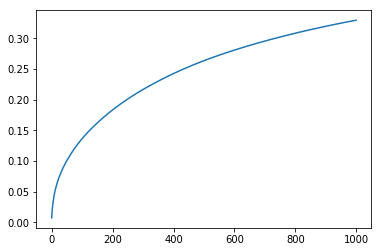

In [113]:
# Scree Plot

plt.plot(np.cumsum(svd.explained_variance_ratio_))

# 1,000 components captures about 30% of the variance

In [114]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
svd = TruncatedSVD(n_components=10)  # will extract 10 "topics"
normalizer = Normalizer() # will give each document a unit norm

lsa = Pipeline(steps=[('tfidf', tfidf), ('svd', svd), ('normalizer', normalizer)])

In [116]:
lsa_sentences = lsa.fit_transform(sentences)

lsa_sentences.shape

(118151, 10)

In [117]:
cluster = KMeans(n_clusters=10)

cluster.fit(lsa_sentences)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [118]:
%%timeit
# time it takes to cluster on the original document-term matrix of shape (118151, 280901)
cluster.fit(tfidf_transformed)

1 loop, best of 3: 4min 15s per loop


In [119]:
%%timeit
# also time the prediction phase of the Kmeans clustering
cluster.predict(tfidf_transformed)

10 loops, best of 3: 120 ms per loop


In [120]:
%%timeit
# time the time to cluster after latent semantic analysis of shape (118151, 10)
cluster.fit(lsa_sentences)
# over 80 times faster than fitting on the original tfidf dataset

1 loop, best of 3: 3.6 s per loop


In [121]:
%%timeit
# also time the prediction phase of the Kmeans clustering after LSA was performed
cluster.predict(lsa_sentences)
# over 4 times faster than predicting on the original tfidf dataset

10 loops, best of 3: 34 ms per loop


In [122]:
# transform texts to a cluster distance space
# each row represents an obsercation
cluster.transform(lsa_sentences).shape

(118151, 10)

In [123]:
predicted_cluster = cluster.predict(lsa_sentences)
predicted_cluster

array([2, 2, 2, ..., 2, 2, 6], dtype=int32)

In [130]:
# Distribution of "topics"
pd.Series(predicted_cluster).value_counts(normalize=True)# create DataFrame of texts and predicted topics
texts_df = pd.DataFrame({'text':sentences, 'topic':predicted_cluster})

texts_df.head()

print "Top terms per cluster:"
original_space_centroids = svd.inverse_transform(cluster.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = lsa.steps[0][1].get_feature_names()
for i in range(10):
    print "Cluster %d:" % i
    print ', '.join([terms[ind] for ind in order_centroids[i, :5]])
    print 

lsa.steps[0][1]

Top terms per cluster:
Cluster 0:
good, breakfast, breakfast good, room, great

Cluster 1:
hotel, recommend, good, recommend hotel, nice hotel

Cluster 2:
clean, room clean, rooms, clean comfortable, comfortable

Cluster 3:
room, room clean, hotel, nice, good

Cluster 4:
great, location, breakfast, hotel, stay

Cluster 5:
stay, hotel, good, enjoyed stay, enjoyed

Cluster 6:
comfortable, bed, clean comfortable, bed comfortable, room

Cluster 7:
nice, room, hotel, staff, nice hotel

Cluster 8:
hotel, room, good, great, stay

Cluster 9:
staff, friendly, staff friendly, helpful, friendly helpful



TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [139]:
# topic prediction 
print cluster.predict(lsa.transform(['I definitely recommend this hotel']))

print cluster.predict(lsa.transform(['super friendly staff. Love it!']))

[1]
[9]
